# Parameter Fitting for Mortals

In [1]:
# Python packages used in this chapter
import matplotlib.pyplot as plt
import numpy as np
import tellurium as te
from SBstoat.namedTimeseries import NamedTimeseries, TIME
from SBstoat.modelFitter import ModelFitter
import SBstoat

In [2]:
# Constants used in this chapter
LINEAR_PATHWAY_DATA = "../common/models/linear_pathway_data.csv"
# Wolf model
WOLF_MODEL = "../common/models/Jana_WolfGlycolysis.antimony"
ENDTIME = 5
NUMPOINT = 100*ENDTIME
WOLF_DATA = "../common/models/wolf_data.csv"

Parameters are constants used in models, such as kinetics contants for reactions.
Although there is often knowledge of likely ranges of parameter values, the appropriate value is often unknown
for a specific model.

To make these ideas concrete, consider a linear pathway consisting of three species ``S1``, ``S2``, and ``S3``. That is, ``S1`` $\rightarrow$ ``S2`` $\rightarrow$ ``S3``.
The Antimony model is shown below.

In [3]:
LINEAR_PATHWAY_MODEL = '''
R1:  S1 -> S2; k1*S1  
R2: S2 -> S3; k2*S2
R3: S3 -> S4; k3*S3
R4: S4 -> S5; k4*S4

S1 = 10

// Parameters
k1 = 0; # Nominal value of parameter
k2 = 0; # Nominal value of parameter
k3 = 0; # Nominal value of parameter
k4 = 0; # Nominal value of parameter
'''

Note that the values of the parameters are 0! This is not because their true value is 0.
Rather, it's because we don't know the value of these parameters.

It is very common to have parameters with unknown values in kinetics models. Typically, we know the range
of the parameter values, but not a suitable value itself.

So, how do we run a model with known values for *all* of its parameters? The answer is that we estimate or **fit paramter values** based on observed data.

For this example, the observational data are in the file specified in ``LINEAR_PATHWAY_DATA``.

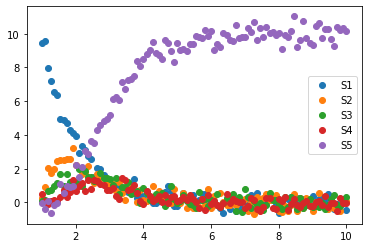

In [4]:
data = NamedTimeseries(csvPath=LINEAR_PATHWAY_DATA)
fig, ax = plt.subplots(1)
for col in data.colnames:
    ax.scatter(data[TIME], data[col])
_ = plt.legend(data.colnames)

## Helper Functions

In [5]:
def plotTS(ts, title=""):
    """
    Plots columns in a timeseries.
    
    Parameters
    ----------
    ts: NamedTimeseries
    """
    p = plt.plot(ts[TIME], ts[ts.colnames])
    _ = plt.legend(p, ts.colnames, bbox_to_anchor=(1.05, 1), loc='upper left')
    _ = plt.title(title)

In [6]:
def makeSyntheticTS(trueTS, proportion):
    """
    Constructs synthetic data in proportion to values of true data.
    
    Parameters
    ----------
    trueTS: NamedTimeseries of true data
    proportion: float indicating the proportional of value to change
    
    Returns
    -------
    NamedTimeseries
    """
    synTS = trueTS.copy()
    for col in synTS.colnames:
        epsilons = np.random.uniform(-1, 1, len(synTS))
        synTS[col] += proportion*synTS[col]*epsilons
    return synTS

The following sections provide details of parameter fitting using the ``PATHWAY_MODEL``.

## Fitting Basics

Some key concepts are:
- A **parameter** is a constant whose value is unknown.
- **Observed data** are data that are used for fitting parameter values.
- **Fitted data** are data produced by a simulation for an assignment of values to parameters.
- **Residuals** are the difference between observed data and simulated data.

The basic algorithm for fitting is described below.
The algorithm estimates ``parameters``, the vector of values of unknown parameters.
The inputs to the algoritm are:
- ``model`` - the simulation model
- ``parameters`` parameters to estimate with their initial values
- ``observedData`` observed data used for fitting

1. **Initialization**
   1. ``fittedData = simulate(model, parameters)``
   1. ``residuals = observedData - fittedData``
1. **Loop**
   1. ``parameters`` = adjust ``parameters`` based on ``residuals``
   1. ``fittedData = simulation(parameters)``
   1. ``residuals = observedData - fittedData``
   1. if ``residuals`` are small
       1. ``return parameters``

The algorithm is fairly straight forward, with one exception.
Step A - "adjust ``parameters`` based on ``residuals``" How are these adjustments made?

The adjustments are made based on an optimization that chooses parameter values that
minimize the residuals.
We give a brief discussion of optimization in the next section.

## Optimization Essentials

Given a function $f(x_1, \cdots, x_n)$, an optimizer finds $(x_1^{\star}, \cdots, x_n^{\star})$
that results in the smallest value of $f(x_1, \cdots, x_n)$.

Sometimes, this search is easy. Consider the curve below.

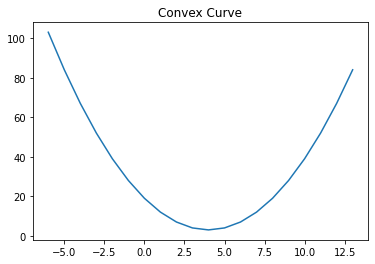

In [7]:
xv = np.array(range(20))
xv = xv - 6
_ = plt.plot(xv, 3 + (xv - 4)**2 )
_ = plt.title("Convex Curve")

We can readily see that the minimum value of this function occurs at $x^{\star} = 4$.
This is an example of a convex curve. A convex curve has the very nice property
that its local minimum is also the global minimum.
That is, there are no small valleys where the optimizer might get "stuck".
For this reason, it's easy to find $x^{\star}$ using gradient decent or
Newton's method.

Unfortunately, convex curves are rare in practice. Much more common is something like the following.

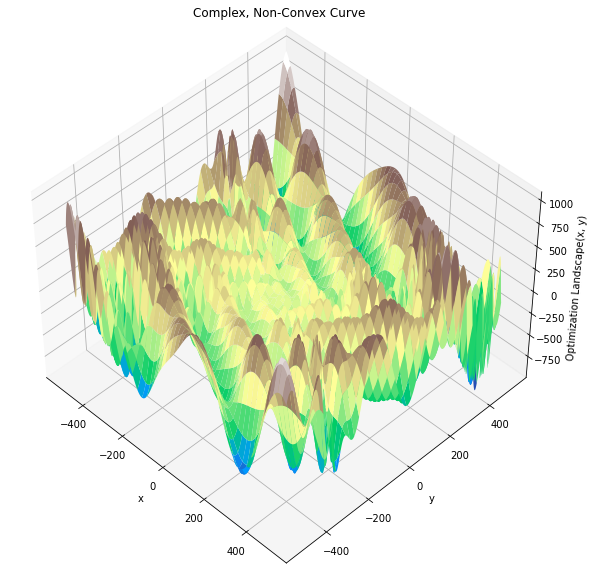

In [8]:
from mpl_toolkits.mplot3d import Axes3D

def eggholder(x):
    return (-(x[1] + 47) * np.sin(np.sqrt(abs(x[0]/2 + (x[1]  + 47))))
          -x[0] * np.sin(np.sqrt(abs(x[0] - (x[1]  + 47)))))

x = np.arange(-512, 513)
y = np.arange(-512, 513)
xgrid, ygrid = np.meshgrid(x, y)
xy = np.stack([xgrid, ygrid])

fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(111, projection='3d')
ax.view_init(45, -45)
ax.plot_surface(xgrid, ygrid, eggholder(xy), cmap='terrain')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('Optimization Landscape(x, y)')
ax.set_title("Complex, Non-Convex Curve")
plt.show()

For curves such as these, hueristic methods are needed such as differential evolution, simulated annealing, and random stochastic
gradient descent.

## Fitting With SBstoat

1. Inputs to and running SBstoat
1. Analysis of output
1. Effect of varying columns to fit
1. Effect of wide parameter range

### Running SBstoat

In [9]:
PARAMETER_DCT = {
    "k1": (1, 50, 100),
    "k2": (1, 50, 100),
    "k3": (1, 50, 100),
    "k4": (1, 50, 100),
    }
def doFit(parameterDct=PARAMETER_DCT, selectedColumns=None):
    model = te.loada(LINEAR_PATHWAY_MODEL)
    fitter = ModelFitter(model, LINEAR_PATHWAY_DATA, parameterDct=parameterDct, selectedColumns=selectedColumns)
    fitter.fitModel()
    print(fitter.reportFit())
    fitter.plotFitAll(figsize=(20, 5), numCol=5, color=["red", "blue"])

/home/ubuntu/reproducible-biomodel-case-study/rcs/lib/python3.6/site-packages/roadrunner/roadrunner.py:3944: UserWarning:

Simulation requested end point (10.0) not reached, because the maximum number of steps reached.  Possible solutions include:
  * Setting an explicit number of points (i.e. r.simulate(1.0, 10.0, 1001)
  * Setting r.integrator.variable_step_size to 'False'
* Setting 



[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 76
    # data points      = 500
    # variables        = 4
    chi-square         = 54.0668310
    reduced chi-square = 0.10900571
    Akaike info crit   = -1104.19360
    Bayesian info crit = -1087.33517
[[Variables]]
    k1:  1.03895724 +/- 0.01731047 (1.67%) (init = 50)
    k2:  2.06807492 +/- 0.06828700 (3.30%) (init = 50)
    k3:  2.70207357 +/- 0.11975021 (4.43%) (init = 50)
    k4:  3.92198591 +/- 0.24973512 (6.37%) (init = 50)
[[Correlations]] (unreported correlations are < 0.100)
    C(k3, k4) = -0.295
    C(k2, k3) = -0.263
    C(k2, k4) = -0.239
    C(k1, k2) = -0.230
    C(k1, k3) = -0.191
    C(k1, k4) = -0.182


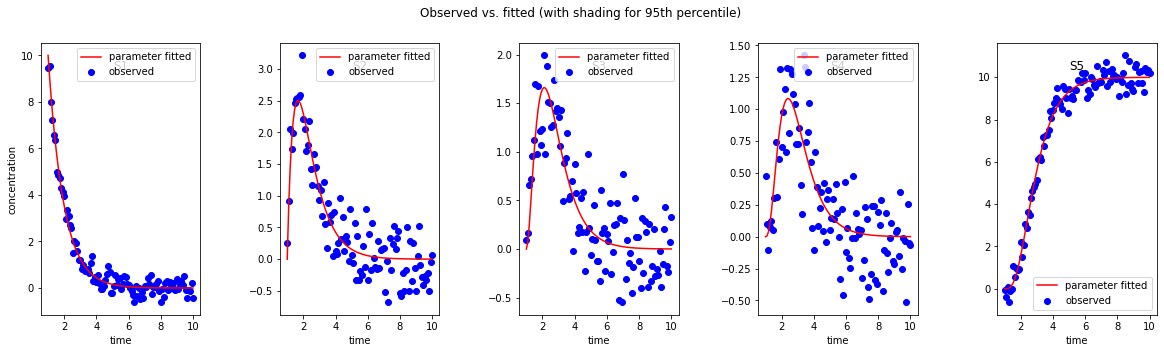

In [10]:
doFit()

### SBstoat Output

### Selecting Columns

### Other Controls over Fitting

1. Parameter ranges
1. Time span

## Fitting for Glycolytic Oscillations

1. Do fit for first 50 (1s) and just J9_k and columns Glucose and Pyruvate
1. Point out challenges with other parameters
1. Story
   a. Focus on Glucose and pyruvate since beginning and end and large values
   b. Try fitting all parameters, all times
   c. Try early time, all parameters

In [27]:
WOLF_PARAMETER_DCT = {
      "J1_n": (1, 1, 8),  # 4
      #"J4_kp": (3600, 36000, 150000),  #76411
      #"J5_k": (10, 10, 160),  # 80
      #"J6_k": (1, 1, 10),  # 9.7
      #"J9_k": (1, 50, 50),   # 28
    }

/home/ubuntu/reproducible-biomodel-case-study/rcs/lib/python3.6/site-packages/roadrunner/roadrunner.py:3944: UserWarning:

Simulation requested end point (5.0) not reached, because the maximum number of steps reached.  Possible solutions include:
  * Setting an explicit number of points (i.e. r.simulate(0.0, 5.0, 1001)
  * Setting r.integrator.variable_step_size to 'False'
* Setting 



[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 16
    # data points      = 500
    # variables        = 1
    chi-square         = 2263.68963
    reduced chi-square = 4.53645216
    Akaike info crit   = 757.071621
    Bayesian info crit = 761.286229
[[Variables]]
    J1_n:  0.99999999 +/- 1.5089e-08 (0.00%) (init = 1)


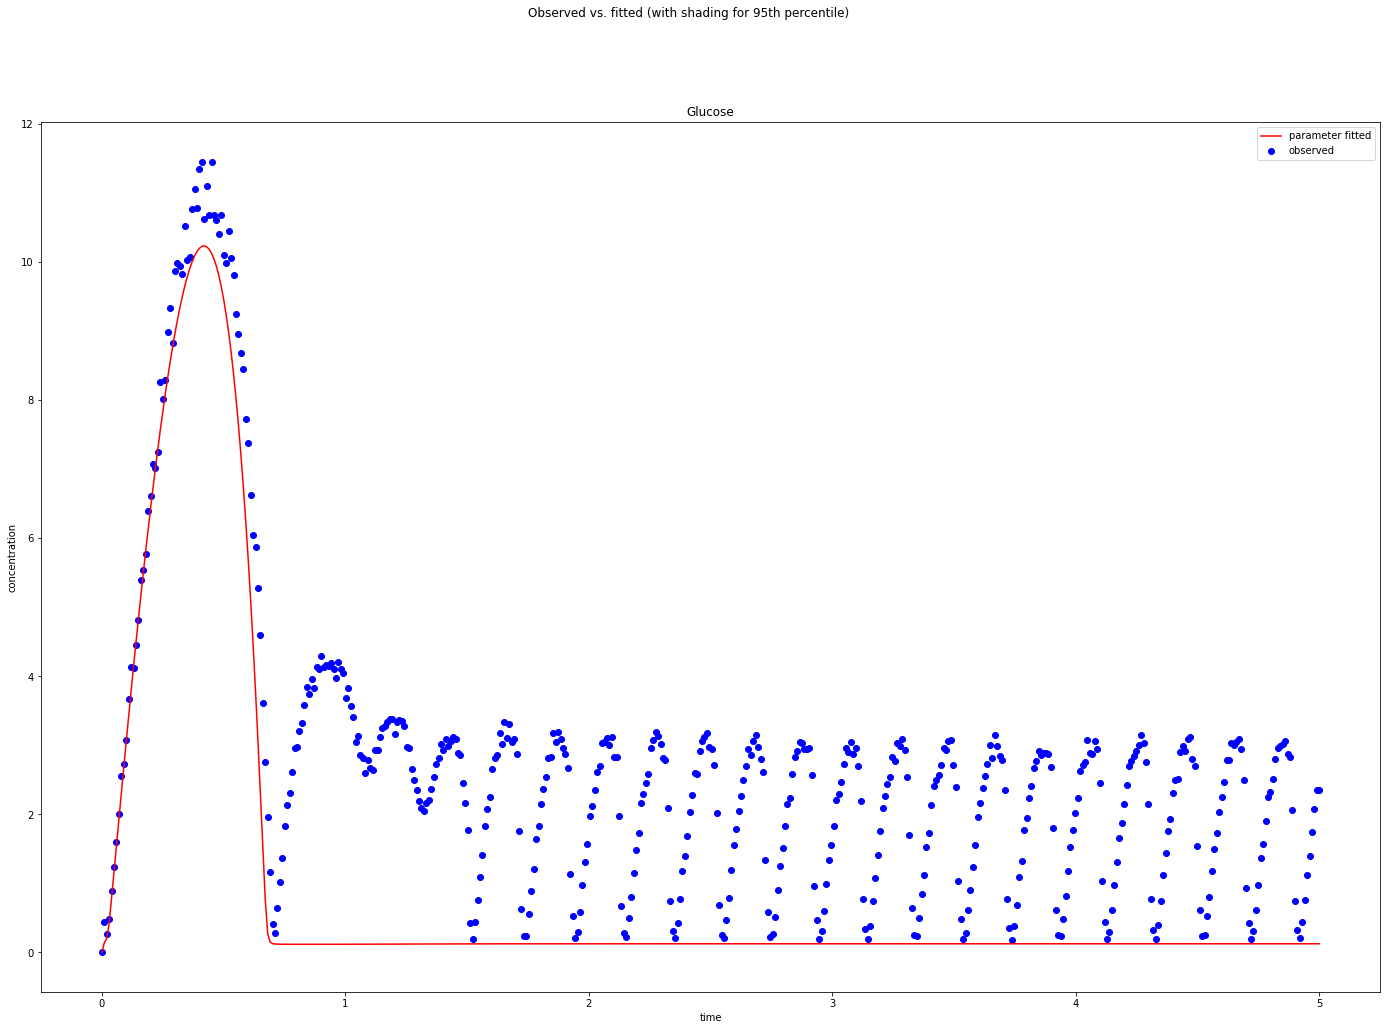

In [28]:
from SBstoat.logs import Logger
parameterDct = {
     # "J1_k1": (250, 250, 1000), # 550
      #"J1_Ki": (0.5, 0.5, 2), # 1
      "J1_n": (1, 1, 8),  # 4
     # "J2_k": (1, 1, 98),  # 9.8
      #"J3_k": (43, 43, 160),  # 85.7
      #"J4_kg": (32.0, 32, 3240),  # 323.8
      "J4_kp": (3600, 36000, 150000),  #76411
     # "J4_ka": (5782, 5782, 578231),  # 57823
     # "J4_kk": (2, 2, 240),  # 23.7
      "J5_k": (40, 40, 160),  # 80
      "J6_k": (5, 5, 10),  # 9.7
     # "J7_k": (200, 200, 20000),  # 2000
     # "J8_k1": (38, 37, 4000),  # 375
     # "J8_k2": (38, 37, 4000),  # 375
      "J9_k": (14, 14, 50),   # 28
     # "J10_k": (8, 700, 800),  # 80,
    }
wolfModel = te.loada(WOLF_MODEL)
ts = NamedTimeseries(WOLF_DATA)
selectedColumns = [ "Glucose"]
#selectedColumns = ts.colnames
newTS = ts
fitter = ModelFitter(wolfModel, newTS, parameterDct=WOLF_PARAMETER_DCT, method=SBstoat.METHOD_DIFFERENTIAL_EVOLUTION, selectedColumns=selectedColumns,
                    logger=Logger(logLevel=5))
fitter.fitModel()
print(fitter.reportFit())
fitter.plotFitAll(figsize=(24,16), numCol=2, color=["red", "blue"], columns=selectedColumns)

## Estimating Parameter Variances With Bootstrapping

## Tips for Fitting

There is considerable art in fitting. The quality of parameter fits
can be improved by exploring the following:
- **What you fit**. This means, which species concentrations you include in the residuals, what part of the time course
you try to fit, and the ranges you choose for parameter values.
- **How you fit**. There are several different algorithms for doing non-linear minimizations...
- **How much compute**. Fitting is computationally intensive. More compute time is often needed for a better result. ``SBstoat`` helps
in this regard by making use of multiple cores.

## Appendix 1 - Synthetic Observational Data for Linear Pathway
This appendix describes how data was generated to create synthetic observations for the linear pathway example.

The first step is to generate data for the "ground truth" model.

In [13]:
# Constants used in this Appendix
LINEAR_PATHWAY_PARAMETER_DCT = {
    "k1": 1.0,
    "k2": 2.0,
    "k3": 3.0,
    "k4": 4.0,
}
LINEAR_PATHWAY_PROPORTION = 0.2

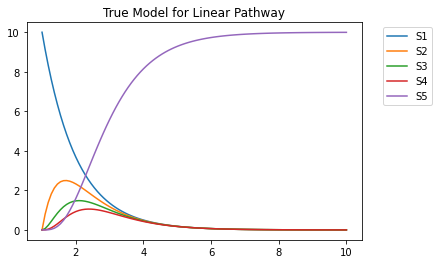

In [14]:
rr = te.loada(LINEAR_PATHWAY_MODEL)
for parameter in LINEAR_PATHWAY_PARAMETER_DCT.keys():
    rr[parameter] = LINEAR_PATHWAY_PARAMETER_DCT[parameter]
trueTS = NamedTimeseries(namedArray=rr.simulate(1, 10, 100))
plotTS(trueTS, title="True Model for Linear Pathway")

Next, we convert the output data, a numpy named array, into a ``NamedTimeseries``, a data structure that is well suited for
time series manipulations.

In [15]:
syntheticTS = makeSyntheticTS(trueTS, LINEAR_PATHWAY_PROPORTION)

Now, we add some random noise. For this example, we add normally distributed random variables with a mean of 0
and a standard deviation of 0.2.

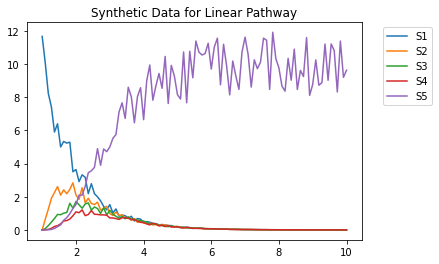

In [16]:
plotTS(syntheticTS, title="Synthetic Data for Linear Pathway")

Last, we write the result to a file.

In [17]:
syntheticTS.to_csv(LINEAR_PATHWAY_DATA)

## Appendix 2 - Synthetic Observational Data for Glycolytic Oscilations

In [18]:
# Constants used in this Appendix
WOLF_PROPORTION = 0.1

This appendix describes how data was generated to create synthetic observations for the Wolf
glycolytic oscillations model.

We see that in this mode there is a large variation in the scale of the values of the time series.

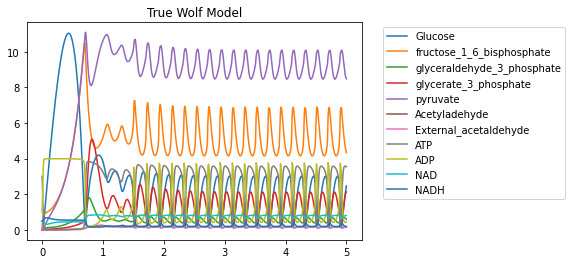

In [19]:
rr = te.loada(WOLF_MODEL)
trueTS = NamedTimeseries(namedArray=rr.simulate(0, ENDTIME, NUMPOINT))
plotTS(trueTS, "True Wolf Model")

So, constructing meaningful synthetic observed data requires some thought.

Our approach is to use a *proportional error model*.
That is, the variability we introduced, which is referred to as *error* in statistics, depends on the true value.
Let $x$ be the true value of the variable, $p$ be the proportion for which we introduce "error",
and $\epsilon$ be a random number chosen uniformly from $[-1, 1]$.
Then, the synthetic observed values is $x (1 +  p \epsilon)$.

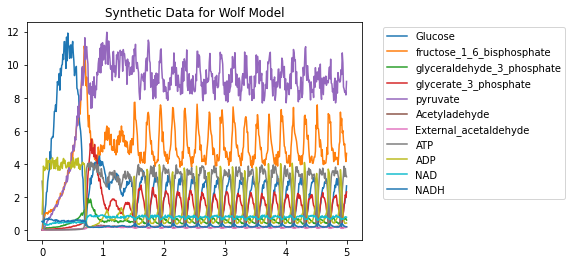

In [20]:
syntheticTS = makeSyntheticTS(trueTS, WOLF_PROPORTION)
plotTS(syntheticTS, title = "Synthetic Data for Wolf Model")

In [21]:
synTS.to_csv(WOLF_DATA)

NameError: name 'synTS' is not defined